In [1]:
from picai_eval import Metrics
import matplotlib.pyplot as plt
import pandas as pd
import os
import nibabel as nib
import seaborn as sns

If you have questions or suggestions, feel free to open an issue at https://github.com/DIAGNijmegen/picai_eval



In [2]:
#Prostate158
path='/nvmescratch/ceib/Prostate/input/prostate158/prostate158_train'
train_df_P158=pd.read_csv(os.path.join(path,'train.csv'))
test_df_P158=pd.read_csv(os.path.join(path,'valid.csv'))

#Picai
data_picai=pd.read_csv('/home/jaalzate/Tartaglia/Prostate_Tartaglia/codes/partition_1.csv')

data_picai["depth"] = data_picai['filepath_t2w_cropped'].apply(lambda path_file: nib.load(path_file).shape[0])
data_picai["heigth"] = data_picai['filepath_t2w_cropped'].apply(lambda path_file: nib.load(path_file).shape[1])
data_picai["weigth"] = data_picai['filepath_t2w_cropped'].apply(lambda path_file: nib.load(path_file).shape[2])
data_picai=data_picai[(data_picai['heigth']!=0) & (data_picai['depth']!=0)]
data_picai=data_picai[(data_picai['heigth']>96) & (data_picai['depth']>96)]



data_picai=data_picai[data_picai['filepath_t2w_cropped'].notna()].reset_index()
data_picai_human=data_picai[data_picai['human_labeled']==1]
data_picai.drop(data_picai_human.index, inplace = True)

#data_picai=data_picai[['filepath_t2w_cropped','filepath_adc_cropped','filepath_hbv_cropped','filepath_labelAI_cropped','filepath_seg_zones_cropped','partition']]
#data_picai_human=data_picai_human[['filepath_t2w_cropped','filepath_adc_cropped','filepath_hbv_cropped','filepath_label_cropped','filepath_seg_zones_cropped','partition']]



columns = ['t2', 'adc', 'dwi','t2_anatomy_reader1', 'adc_tumor_reader1']

for df in [train_df_P158, test_df_P158]:
    for column in columns:
        df[column] = df[column].apply(lambda x: os.path.join(path,x))


test_picai=data_picai[data_picai['partition']=='test']
test_picai_human=data_picai_human[data_picai_human['partition']=='test']

test_df = pd.DataFrame({
    't2w': list(test_picai['filepath_t2w_cropped'].values) + list(test_picai_human['filepath_t2w_cropped'].values)+list(test_df_P158['t2'].values),
    'adc': list(test_picai['filepath_adc_cropped'].values) +  list(test_picai_human['filepath_adc_cropped'].values)+list(test_df_P158['adc'].values) ,
    'dwi': list(test_picai['filepath_hbv_cropped'].values) + list(test_picai_human['filepath_hbv_cropped'].values)+list(test_df_P158['dwi'].values),
    'zones': list(test_picai['filepath_seg_zones_cropped'].values) + list(test_picai_human['filepath_seg_zones_cropped'].values)+list(test_df_P158['t2_anatomy_reader1'].values),
    'label': list(test_picai['filepath_labelAI_cropped'].values) + list(test_picai_human['filepath_label_cropped'].values)+list(test_df_P158['adc_tumor_reader1'].values),
    'label_csPCa':list(test_picai['label'].values) + list(test_picai_human['label'].values)+[None]*len(test_df_P158),
    'PIR':list(test_picai['PIRADS'].values) + list(test_picai_human['PIRADS'].values)+[None]*len(test_df_P158)
})

In [3]:
def plot_roc_curves(fpr_list, tpr_list, aucroc_list, labels,filename=None):
    """
    Plots multiple ROC curves in a single figure using Seaborn.

    Args:
        fpr_list (list): List of false positive rates for each ROC curve.
        tpr_list (list): List of true positive rates for each ROC curve.
        labels (list): List of labels for each ROC curve.
        aucroc_list (list): List of AUC for each ROC curve.
        filename (str): Output filename to save the figure as a PDF. Default: None.


    Returns:
        None
    """

    # Set Seaborn style
    sns.set(style='whitegrid')

    # Create a new figure
    plt.figure(figsize=(8, 6))

    # Iterate over each set of false positive rates and true positive rates
    for fpr, tpr, auc, label in zip(fpr_list, tpr_list, aucroc_list, labels):
        # Plot the ROC curve
        plt.plot(fpr, tpr, lw=2, label='%s (AUC = %0.2f)' % (label, auc))

    # Plot the random guessing ROC curve
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')

    # Set the plot limits, labels, title, and legend
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('Receiver Operating Characteristic (ROC)', fontsize=14)
    plt.legend(loc="lower right", fontsize=10)

    # Adjust spacing and padding
    
    # Save the plot as a PDF if filename is provided
    if filename is not None:
        plt.savefig(filename, format='png')

    plt.tight_layout()

    # Show the plot
    plt.show()
    

def plot_precision_recall_curves(precision_list, recall_list, labels, average_precision_list):
    """
    Plots precision-recall curves for multiple models in a single figure using Seaborn.

    Args:
        precision_list (list): List of precision values for each model.
        recall_list (list): List of recall values for each model.
        labels (list): List of labels for each model.
        average_precision_list (list): List of average precision values for each model. Default: None.

    Returns:
        None
    """

    # Set Seaborn style
    sns.set(style='whitegrid')

    # Create a new figure
    plt.figure(figsize=(8, 6))

    # Iterate over each set of precision and recall values
    for precision, recall, label,AP in zip(precision_list, recall_list, labels,average_precision_list):
        # Plot the precision-recall curve
        plt.plot(recall, precision, lw=2, label='%s (AP = %0.2f)' % (label, AP))

    # Set the plot limits, labels, and title
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.title('Precision-Recall Curve', fontsize=14)
    plt.legend(loc="lower left", fontsize=10)

    # Show the plot
    plt.show()


In [12]:
#subject_list= [str(i) for i in test_df[test_df.label_csPCa==1].index] #Test only in patients with positive clinically significant prostate cancer
subject_list= [str(i) for i in test_df.index]
#subject_list= [str(i) for i in test_df[test_df.PIR==5].index]

In [13]:
metrics_unet = Metrics("/home/jaalzate/Tartaglia/Prostate_Tartaglia/Paper_Resultados/Results/Unet/metrics_unet.json",subject_list=subject_list)
metrics_unetr = Metrics("/home/jaalzate/Tartaglia/Prostate_Tartaglia/Paper_Resultados/Results/Unetr/metrics_unetr.json",subject_list=subject_list)
metrics_swinunetr = Metrics("/home/jaalzate/Tartaglia/Prostate_Tartaglia/Paper_Resultados/Results/SwinUnetr/metrics_swinunet.json",subject_list=subject_list)
metrics_sam_pretrained = Metrics("/home/jaalzate/Tartaglia/Prostate_Tartaglia/Paper_Resultados/Results/SAMUnetr/pretrained/metrics_samunetr_pretrained.json",subject_list=subject_list)
metrics_sam_no_pretrained = Metrics("/home/jaalzate/Tartaglia/Prostate_Tartaglia/Paper_Resultados/Results/SAMUnetr/no_pretrained/metrics_samunetr_no_pretrained.json",subject_list=subject_list)

print('Results UNET: ',metrics_unet )
print('Results UNETR: ', metrics_unetr)
print('Results SWINUNETR: ', metrics_swinunetr)
print('Results SAM-UNETR pretrained: ', metrics_sam_pretrained)
print('Results SAM-UNETR no pretrained: ', metrics_sam_no_pretrained)

Results UNET:  Metrics(auroc=67.24%, AP=24.51%, 318 cases, 102 lesions)
Results UNETR:  Metrics(auroc=66.40%, AP=26.96%, 318 cases, 102 lesions)
Results SWINUNETR:  Metrics(auroc=73.96%, AP=28.30%, 318 cases, 102 lesions)
Results SAM-UNETR pretrained:  Metrics(auroc=77.06%, AP=28.03%, 318 cases, 102 lesions)
Results SAM-UNETR no pretrained:  Metrics(auroc=73.21%, AP=26.82%, 318 cases, 102 lesions)


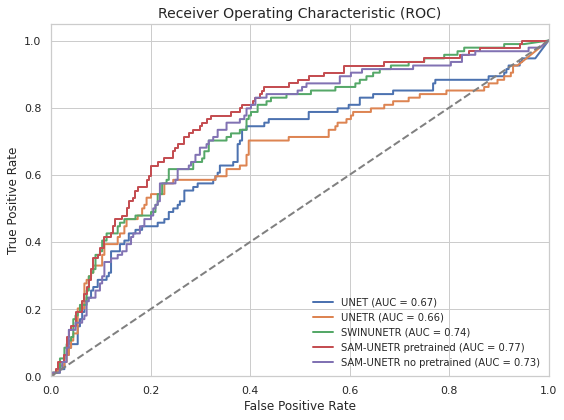

In [84]:
#ROC curve
aucroc_unet = metrics_unet.auroc
tpr_unet = metrics_unet.case_TPR
fpr_unet = metrics_unet.case_FPR

aucroc_unetr = metrics_unetr.auroc
tpr_unetr = metrics_unetr.case_TPR
fpr_unetr = metrics_unetr.case_FPR

aucroc_swinunetr = metrics_swinunetr.auroc
tpr_swinunetr = metrics_swinunetr.case_TPR
fpr_swinunetr = metrics_swinunetr.case_FPR

aucroc_sam_pretrained = metrics_sam_pretrained.auroc
tpr_sam_pretrained = metrics_sam_pretrained.case_TPR
fpr_sam_pretrained = metrics_sam_pretrained.case_FPR

aucroc_sam_no_pretrained = metrics_sam_no_pretrained.auroc
tpr_sam_no_pretrained = metrics_sam_no_pretrained.case_TPR
fpr_sam_no_pretrained = metrics_sam_no_pretrained.case_FPR


labels=['UNET','UNETR','SWINUNETR','SAM-UNETR pretrained','SAM-UNETR no pretrained']
tpr_list=[tpr_unet,tpr_unetr,tpr_swinunetr,tpr_sam_pretrained,tpr_sam_no_pretrained]
fpr_list=[fpr_unet,fpr_unetr,fpr_swinunetr,fpr_sam_pretrained,fpr_sam_no_pretrained]
auc_list=[aucroc_unet,aucroc_unetr,aucroc_swinunetr,aucroc_sam_pretrained,aucroc_sam_no_pretrained]
filename='/home/jaalzate/Tartaglia/Prostate_Tartaglia/Paper_Resultados/Results/ROC_Curve.png'


plot_roc_curves(fpr_list,tpr_list,auc_list,labels,filename=filename)

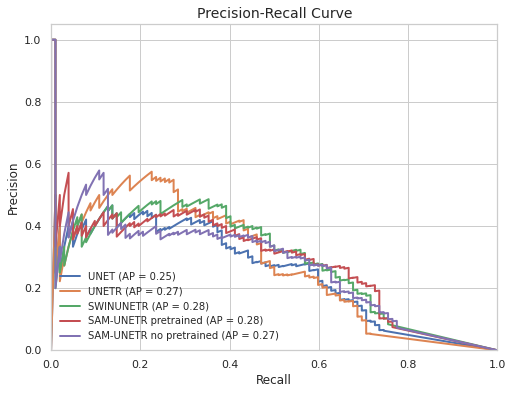

In [85]:
#Precision-Recall curve

AP_unet = metrics_unet.AP
precision_unet = metrics_unet.precision
recall_unet = metrics_unet.recall

AP_unetr = metrics_unetr.AP
precision_unetr = metrics_unetr.precision
recall_unetr = metrics_unetr.recall

AP_swinunetr = metrics_swinunetr.AP
precision_swinunetr = metrics_swinunetr.precision
recall_swinunetr = metrics_swinunetr.recall

AP_sam_pretrained = metrics_sam_pretrained.AP
precision_sam_pretrained = metrics_sam_pretrained.precision
recall_sam_pretrained = metrics_sam_pretrained.recall

AP_sam_no_pretrained = metrics_sam_no_pretrained.AP
precision_sam_no_pretrained = metrics_sam_no_pretrained.precision
recall_sam_no_pretrained = metrics_sam_no_pretrained.recall


labels=['UNET','UNETR','SWINUNETR','SAM-UNETR pretrained','SAM-UNETR no pretrained']
precision_list=[precision_unet,precision_unetr,precision_swinunetr,precision_sam_pretrained,precision_sam_no_pretrained]
recall_list=[recall_unet,recall_unetr,recall_swinunetr,recall_sam_pretrained,recall_sam_no_pretrained]
AP_list=[AP_unet,AP_unetr,AP_swinunetr,AP_sam_pretrained,AP_sam_no_pretrained]

plot_precision_recall_curves(precision_list, recall_list, labels, average_precision_list=AP_list)